In [55]:
import random
random.seed(42)

import numpy as np
np.random.seed(42)


data_shape = 256


In [56]:

from PIL import Image
from IPython.display import display
import numpy as np
import cv2

# origin: buildings with height
# building: buildings without height
# target: the ground truth
# source: the antenna

root_origin = './png/buildingsWHeight/'
root_building = './png/buildings_complete/'
root_target = './gain/'
root_source = './png/antennasWHeight/'

root_pre = './pre/'


def get_origin_data(pic_id, idx, noscale=False):
    img_origin = Image.open(root_origin+str(pic_id)+'.png')
    img_building = Image.open(root_building+str(pic_id)+'.png')
    img_target = Image.open(root_target+str(pic_id)+'_'+str(idx)+'.png')
    img_source = Image.open(root_source+str(pic_id)+'_'+str(idx)+'.png')

    
    origin_data = np.array(img_origin.resize((data_shape, data_shape)))
    building_data = np.array(img_building.resize((data_shape, data_shape)))
    target_data = np.array(img_target.resize((data_shape, data_shape)))
    source_data = np.array(img_source.resize((data_shape, data_shape)))
    
    

    source = source_data.nonzero()
    source = list(zip(*source))
    source = np.array(source[0])

    return origin_data, building_data, target_data, source


In [57]:

class IMG_COLOR:
    def __init__(self, img):
        self.img = img
        try:
            self.img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        except:
            pass

    def copy(self):
        return IMG_COLOR(self.img.copy())
    
    def draw_point(self, point, color, radius=1):
        cv2.circle(self.img, (int(point[1]), int(point[0])), radius, color, -1)

    def draw_line(self, point1, point2, color, width=1, line_type=cv2.LINE_8):
        cv2.line(self.img, (int(point1[1]), int(point1[0])), (int(point2[1]), int(point2[0])), color, width, line_type)

    def display(self):
        display(Image.fromarray(self.img))


    def draw_wall(self, wall_info):

        for wall in wall_info:
            point0 = wall[0]
            point1 = wall[1]
            mid_point = wall[2]
            angle = wall[4]

            if angle > 0:
                self.draw_line(point0, point1, (0, 255, 0), 2, cv2.LINE_8)
            else:
                self.draw_line(point0, point1, (255, 0, 0), 2, cv2.LINE_8)

            # self.draw_point(mid_point, (128, 128, 128))

    

In [58]:

def get_distance(point1, point2):

    # return abs(point1[0]-point2[0]) + abs(point1[1]-point2[1])
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)


def is_air(x, y, building_data):
    return building_data[x][y] == 0

In [59]:
# EDGE -- visibility

def bresenham(x1, y1, x2, y2):
    '''Bresenham's line algorithm: get all the points on the segment (int form)'''
    points = []
    dx = x2 - x1
    dy = y2 - y1
    is_steep = abs(dy) > abs(dx)  # 判断斜率是否大于1
    
    # 如果斜率大于1，交换x和y的值
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    
    # 如果起点大于终点，则交换起点和终点
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    
    dx = x2 - x1
    dy = y2 - y1
    
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
    
    y = y1
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
    
    # 如果起点和终点被交换了，我们需要反转列表
    if swapped:
        points.reverse()
    return points


def is_visible(point1, point2, img, dist_limit=50):
    '''connect two point then check whether the line is across the building'''

    x1 = int(point1[0])
    y1 = int(point1[1])

    x2 = int(point2[0])
    y2 = int(point2[1])

    distance = get_distance(point1, point2)

    flag = True

    if distance < dist_limit:
        points = bresenham(x1, y1, x2, y2)
        for point in points:
            if point == (x1, y1) or point == (x2, y2):
                continue
            if img[point[0]][point[1]] > 0:
                flag = False
            else:
                continue
    else:
        flag = False

    return flag



In [60]:

import networkx as nx
from itertools import combinations


def Build_Graph(building_data, target_data, wall_info, source, img_color:IMG_COLOR, draw=False):
    # BUILDING THE GRAPH

    # NODE TYPE:
    NODE_WALL = [1, 0, 0, 0]
    NODE_ANTENNA = [0, 1, 0, 0]
    NODE_GRID = [0, 0, 1, 0]
    NODE_AIR = [0, 0, 0, 1]

    # EDGE TYPE:
    EDGE_WALL2WALL = [1, 0, 0, 0]
    EDGE_WALL2ANTENNA = [1, 1, 0, 0]; EDGE_WALL2ANTENNA_INVISIBLE = [-1, -1, 0, 0]
    EDGE_WALL2GRID = [1, 0, 1, 0]
    EDGE_ANTENNA2GRID = [0, 1, 1, 0]; EDGE_ANTENNA2GRID_INVISIBLE = [0, -1, -1, 0]
    EDGE_GRID2GRID = [0, 0, 1, 0]
    EDGE_GRID2AIR = [0, 0, 1, 1]




    G = nx.Graph()


    # NODE1 -- walls on buildings
    for i, wall in enumerate(wall_info):
        G.add_node(i, y=0, begin = wall[0]-source, end = wall[1]-source, mid = wall[2]-source, length = wall[3], angle = wall[4], height = wall[5], type = NODE_WALL, is_air = False)

    # EDGE1 -- wall2wall
    walls_edge_cnt = 0
    for pair in list(combinations(wall_info, 2)):
        if is_visible(pair[0][2], pair[1][2], building_data, dist_limit=48):
            G.add_edge(wall_info.index(pair[0]), wall_info.index(pair[1]), type = EDGE_WALL2WALL, dist = get_distance(pair[0][2], pair[1][2]))
            img_color.draw_line(pair[0][2], pair[1][2], (128, 128, 128), 1)
            walls_edge_cnt = walls_edge_cnt + 1


    # print("number of wall connections:", walls_edge_cnt)
    # print()


    img_A = img_color.copy()

    # NODE2 -- antenna
    G.add_node('A', y=255, begin = [0, 0], end = [0, 0], mid = [0, 0], length = 0, angle = 0, height = 50, type = NODE_ANTENNA, is_air = False)
    img_A.draw_point(source, (0, 0, 256), 4)


    # EDGE2 -- wall2antenna
    for wall in G.nodes:
        if G.nodes[wall]['type'] == NODE_WALL:
            if is_visible(G.nodes[wall]['mid']+source, source, building_data, dist_limit=128):
                G.add_edge(wall, 'A', type = EDGE_WALL2ANTENNA, dist = get_distance(G.nodes[wall]['mid'], [0, 0]))
                img_A.draw_line(G.nodes[wall]['mid']+source, source, (0, 0, 256), 2)
            # else:
            #     G.add_edge(wall, 'A', type = EDGE_WALL2ANTENNA_INVISIBLE, dist = get_distance(G.nodes[wall]['mid'], source))
            #     img_A.draw_line(G.nodes[wall]['mid'], source, (0, 0, 128), 1)

    print('antenna and its connections to walls: ')
    if draw: img_A.display()


    img_grid = img_color.copy()

    # NODE3 -- grid points
    density = 64 # the number of grids in each row and column
    gap = data_shape // density
    for i in range(density):
        for j in range(density):
            # x = i * gap + gap // 2
            # y = j * gap + gap // 2
            x = i * gap
            y = j * gap
            if is_air(x, y, building_data):
                G.add_node((i, j, 3), y=target_data[x][y], begin = (x-source[0], y-source[1]), end = (x-source[0], y-source[1]), mid = (x-source[0], y-source[1]), length = 0, angle = 0, height = 0, type = NODE_GRID, is_air = False)
                img_grid.draw_point((x, y), (256, 0, 0), 1)


    # EDGE3 -- wall2grid
    for pair in list(combinations(G.nodes, 2)):
        if (G.nodes[pair[0]]['type'] == NODE_WALL and G.nodes[pair[1]]['type'] == NODE_GRID) or (G.nodes[pair[0]]['type'] == NODE_GRID and G.nodes[pair[1]]['type'] == NODE_WALL):
            if is_visible(G.nodes[pair[0]]['mid']+source, G.nodes[pair[1]]['mid']+source, building_data, dist_limit=64):
                G.add_edge(pair[0], pair[1], type = EDGE_WALL2GRID, dist = get_distance(G.nodes[pair[0]]['mid'], G.nodes[pair[1]]['mid']))
                img_grid.draw_line(G.nodes[pair[0]]['mid']+source, G.nodes[pair[1]]['mid']+source, (128, 256, 128), 1)

    # EDGE4 -- antenna2grid
    for grid in G.nodes:
        if G.nodes[grid]['type'] == NODE_GRID:
            if is_visible(G.nodes[grid]['mid']+source, source, building_data, dist_limit=64):
                G.add_edge('A', grid, type = EDGE_ANTENNA2GRID, dist = get_distance(G.nodes[grid]['mid'], [0, 0]))
                img_grid.draw_line(G.nodes[grid]['mid']+source, source, (128, 256, 0), 2)
            # else:
            #     G.add_edge('A', grid, type = EDGE_ANTENNA2GRID_INVISIBLE, dist = get_distance(G.nodes[grid]['mid'], source))
            #     img_grid.draw_line(G.nodes[grid]['mid'], source, (0, 64, 0), 1)

    # EDGE5 -- grid2grid
    for i in range(density):
        for j in range(density):
            if (i, j, 3) in G.nodes:
                if ((i+1), j, 3) in G.nodes:
                    G.add_edge((i, j, 3), ((i+1), j, 3), type = EDGE_GRID2GRID, dist = gap)
                    # img_grid.draw_line(G.nodes[(i, j, 3)]['mid'], G.nodes[((i+1), j, 3)]['mid'], (0, 256, 0), 1)
                if (i, (j+1), 3) in G.nodes:
                    G.add_edge((i, j, 3), (i, (j+1), 3), type = EDGE_GRID2GRID, dist = gap)
                    # img_grid.draw_line(G.nodes[(i, j, 3)]['mid'], G.nodes[(i, (j+1), 3)]['mid'], (0, 256, 0), 1)


    print('grid and its connections to walls and antenna: ')
    if draw: img_grid.display()

    
    # # NODE4 -- points of air to be predicted
    # img_air = img_color.copy()
    # for i in range(data_shape):
    #     for j in range(data_shape):
    #         if is_air(i, j, building_data):
    #             G.add_node((i, j), y = target_data[i][j], begin = (i-source[0], j-source[1]), end = (i-source[0], j-source[1]), mid = (i-source[0], j-source[1]), length = 0, angle = 0, height = 0, type = NODE_AIR, is_air = True)
    #             img_air.draw_point((i, j), (256, 0, 0), 1)
    # # EDGE6 -- grid2air
    #             if ((i//gap), (j//gap), 3) in G.nodes:
    #                 G.add_edge((i, j), ((i//gap), (j//gap), 3), type = EDGE_GRID2AIR, dist = get_distance((0,0), (abs(i-gap//2), abs(j-gap//2))))

    # print('air points: ')
    # if draw: img_air.display()

    print(G)
    # print(list(G.nodes)[1000:1040]) # check the negtive nodes
    # visualize_graph(G, G.nodes, "Graph with only walls")
    
    return G


In [61]:

from torch_geometric.utils import from_networkx
import torch

def Build_Data(G):
    data = from_networkx(G)
    print(data)

    data.x = np.concatenate((data.begin, data.end, data.mid, data.length.reshape(-1, 1), data.angle.reshape(-1, 1), data.height.reshape(-1, 1), data.type, data.is_air.reshape(-1, 1)), axis=1)
    data.edge_attr = np.concatenate((data.dist.reshape(-1, 1), data.edge_type), axis=1)
    # data.edge_attr = data.edge_type  # for GCNConv


    data.x = torch.tensor(data.x, dtype=torch.float)
    data.y = torch.tensor(data.y, dtype=torch.int16)
    data.edge_attr = torch.tensor(data.edge_attr, dtype=torch.float)

    print(data.x.shape[1], 'dimensions of input features')
    print(data.edge_attr.shape[1], 'dimensions of edge features')
    print(data)

    return data


def Save_Data(data, pic_id, idx):
    torch.save(data, root_pre+str(pic_id)+'_'+str(idx)+'.pt')
    print('data', pic_id, '_', idx, 'saved')


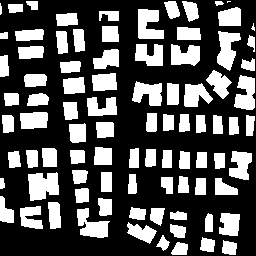

number of walls:  492
example of wall_it information:  [[60, 200], [46, 200], [53, 200], 14.0, -1.5707963267948966, 94]


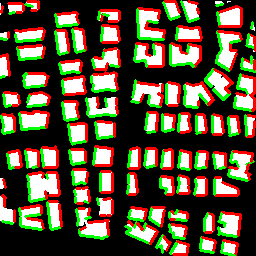

In [62]:
# Preprocess data about buildings


pic_id = 1
# idx = 0

origin_data, building_data, _, _ = get_origin_data(pic_id, 0, noscale=True)



img_color = IMG_COLOR(building_data)

display(Image.fromarray(building_data))


def is_neg_angle(mid_point, building_data):
    # convolution matrix
    # -1 -1 -1
    #  1  1 -1
    #  1  1 -1

    img = np.where(building_data > 0, 1, -1) # 1 for building, -1 for background
    
    check_matrix = np.array([[-1, -1, -1],
                             [1, 1, -1],
                             [1, 1, -1]])
    if mid_point[1] < 1 or mid_point[0] > data_shape-2:
        return True
    elif mid_point[0] < 1 or mid_point[1] > data_shape-2:
        return False
    
    cdot = 0   # convolution result
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            cdot = cdot + check_matrix[i+1][j+1] * img[int(mid_point[0])+i][int(mid_point[1])+j]
    
    return cdot > 0

def calc_angle(x1, x0, y1, y0, flag):
        if y1-y0 == 0:
            angle = np.pi/2
        else:
            angle = np.arctan(np.abs((x1-x0)/(y1-y0)))
        
        if flag:
            angle = angle - np.pi
        
        return angle

def get_origin_height(point, img_origin):
    x0 = int(point[0])
    y0 = int(point[1])
    # 竟然tmd是反的搞了半天

    marginal_value = 0

    if img_origin[x0][y0] > 0:
        return img_origin[x0][y0]
    else:
        if x0 < 1 or x0 > data_shape-2 or y0 < 1 or y0 > data_shape-2:
            return marginal_value
        else:
            max_value = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    max_value = max(max_value, img_origin[x0+i][y0+j])
            if max_value == 0:
                print('error: invalid height information')

            return max_value

def get_wall_info(img_origin, img ,scale=1.01):
    lsd = cv2.createLineSegmentDetector(0, scale=scale)
    dlines = lsd.detect(img)

    if dlines is None:
        return None

    wall = []
    for dline in dlines[0]:
        y0 = int(round(dline[0][0]))
        x0 = int(round(dline[0][1]))
        y1 = int(round(dline[0][2]))
        x1 = int(round(dline[0][3]))

        point0 = [x0, y0]
        point1 = [x1, y1]
        mid_point = [(x0+x1)//2, (y0+y1)//2]
        length = np.sqrt((x0-x1)**2 + (y0-y1)**2)
        height = get_origin_height(mid_point, img_origin)
        # node_dist = get_distance(mid_point, source)

    # angles: lower and left side of the wall is positive, upper and right side of the wall is negative
        flag = is_neg_angle(mid_point, img)
        angle = calc_angle(x0, x1, y0, y1, flag)
        # cv2.line(img_color, (y0, x0), (y1, x1), (0, 0, 255), 5, cv2.LINE_8)
        # print('angle: ', angle)
        # display(Image.fromarray(img_color))
        # import time
        # time.sleep(3)
        
        wall.append([point0, point1, mid_point, length, angle, height])
    
    return wall


wall_info = get_wall_info(origin_data, building_data)
print('number of walls: ', len(wall_info))
print('example of wall_it information: ', wall_info[0])


img_angle = img_color.copy()
img_angle.draw_wall(wall_info)
img_angle.display()


antenna and its connections to walls: 


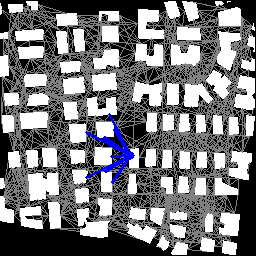

grid and its connections to walls and antenna: 


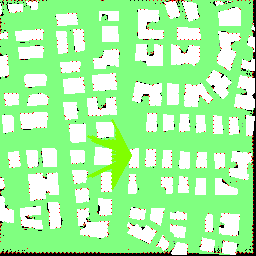

Graph with 3240 nodes and 37149 edges
Data(edge_index=[2, 74298], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74298, 4], dist=[74298], num_nodes=3240)
14 dimensions of input features
5 dimensions of edge features
Data(edge_index=[2, 74298], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74298, 4], dist=[74298], num_nodes=3240, x=[3240, 14], edge_attr=[74298, 5])
data 1 _ 0 saved
Data(edge_index=[2, 74298], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74298, 4], dist=[74298], num_nodes=3240, x=[3240, 14], edge_attr=[74298, 5])
----------------- 0 --------------------


/var/folders/cp/8y364cps3g3b48m_yvr4zljw0000gn/T/ipykernel_16925/3322326887.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(data.y, dtype=torch.int16)


antenna and its connections to walls: 


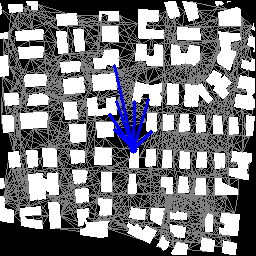

grid and its connections to walls and antenna: 


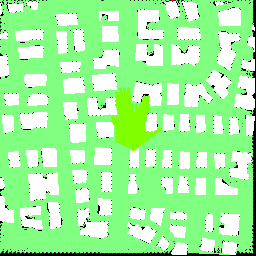

Graph with 3240 nodes and 37198 edges
Data(edge_index=[2, 74396], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74396, 4], dist=[74396], num_nodes=3240)
14 dimensions of input features
5 dimensions of edge features
Data(edge_index=[2, 74396], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74396, 4], dist=[74396], num_nodes=3240, x=[3240, 14], edge_attr=[74396, 5])
data 1 _ 1 saved
Data(edge_index=[2, 74396], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74396, 4], dist=[74396], num_nodes=3240, x=[3240, 14], edge_attr=[74396, 5])
----------------- 1 --------------------
antenna and its connections to walls: 


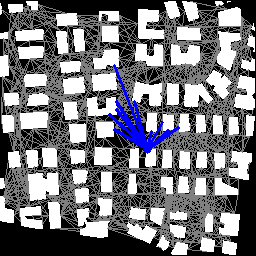

grid and its connections to walls and antenna: 


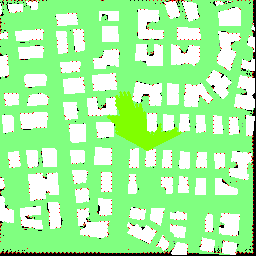

Graph with 3240 nodes and 37204 edges
Data(edge_index=[2, 74408], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74408, 4], dist=[74408], num_nodes=3240)
14 dimensions of input features
5 dimensions of edge features
Data(edge_index=[2, 74408], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74408, 4], dist=[74408], num_nodes=3240, x=[3240, 14], edge_attr=[74408, 5])
data 1 _ 2 saved
Data(edge_index=[2, 74408], y=[3240], begin=[3240, 2], end=[3240, 2], mid=[3240, 2], length=[3240], angle=[3240], height=[3240], type=[3240, 4], is_air=[3240], edge_type=[74408, 4], dist=[74408], num_nodes=3240, x=[3240, 14], edge_attr=[74408, 5])
----------------- 2 --------------------
antenna and its connections to walls: 


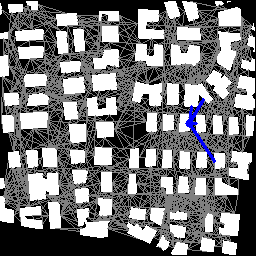

KeyboardInterrupt: 

In [63]:
num_data = 80

for idx in range(num_data):

    _, _, target_data, source = get_origin_data(pic_id, idx)

    G = Build_Graph(building_data, target_data, wall_info, source, img_color, draw=True)

    data = Build_Data(G)

    Save_Data(data, pic_id, idx)

    print(data)

    print(f'----------------- {idx} --------------------')